<a href="https://colab.research.google.com/github/sjpark0605/NLP-FYP/blob/main/Food_Recipe_Pipeline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [129]:
%%capture
!pip install transformers[sentencepiece]

In [130]:
project_dir = '/content/drive/MyDrive/COMP0029/'

In [131]:
import torch

device = torch.device('cpu')

if torch.cuda.is_available():
  device = torch.device('cuda')

In [132]:
from transformers import pipeline, BertTokenizer, AutoModelForTokenClassification

ner_model = AutoModelForTokenClassification.from_pretrained(project_dir + 'saved_models/ner/ner-model').to(device)
ner_tokenizer = BertTokenizer.from_pretrained('bert-base-cased')

ner_id2label = ner_model.config.id2label

def obtain_ner_tags(sentences):
  word_dict, ner_dict = {}, {}

  for i, sentence in enumerate(sentences):
    input = ner_tokenizer.encode_plus(sentence, truncation=True, max_length=150, return_tensors='pt').to(device)

    tokens = ner_tokenizer.convert_ids_to_tokens(input["input_ids"].squeeze())
    logits = ner_model(**input).get("logits")
    predictions = logits.argmax(dim=-1).squeeze()

    joined_words, joined_labels = [], []

    for token, prediction in zip(tokens, predictions):
      if token.startswith('##'):
        joined_words[-1] += token.replace('##', '')
      elif token != '[CLS]' and token != '[SEP]':
        joined_words.append(token)
        joined_labels.append(ner_id2label[prediction.item()])

    for j, (word, label) in enumerate(zip(joined_words, joined_labels)):
      word_dict[(i, j)] = word
      ner_dict[(i, j)] = label
  
  return word_dict, ner_dict

In [133]:
import nltk

nltk.download('punkt')

def split_text_into_sentences(text):
  sentences = nltk.sent_tokenize(text)
  return sentences

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [134]:
from transformers import pipeline, BertTokenizer, AutoModelForSequenceClassification

flow_model = AutoModelForSequenceClassification.from_pretrained(project_dir + 'saved_models/entity_marking/flow-graph-optimized-parameter-model').to(device)
flow_tokenizer = tokenizer = BertTokenizer.from_pretrained(project_dir + 'tokenizers/entity-marker')

flow_id2label = flow_model.config.id2label

In [135]:
import pickle

with open(project_dir + "relation_set.pickle", "rb") as relation_set_file:
  RELATION_SET = pickle.load(relation_set_file)

def construct_entity_pairs(ner_dict):
  entity_pairs = []

  ner_keys = list(ner_dict.keys())

  for i in range(len(ner_keys)):
    for j in range(i + 1, len(ner_keys)):
      pair1 = ner_dict[ner_keys[i]] + "->" + ner_dict[ner_keys[j]]
      pair2 = ner_dict[ner_keys[j]] + "->" + ner_dict[ner_keys[i]]

      if pair1 in RELATION_SET or pair2 in RELATION_SET:
        entity_pairs.append((ner_keys[i], ner_keys[j]))

  return entity_pairs

In [136]:
def construct_sentence(word_dict, ner_dict, sentence_index, target_positions):
  word_keys = sorted(list(word_dict.keys()))

  first_word = True

  sentence = ""

  marking = -1
  marking_ner_tag = None

  for word_key in word_keys:
    word = word_dict[word_key]
    word_added = False

    if sentence_index == word_key[0]:
      if marking != -1:        
        if marking_ner_tag.replace('-B', '-I') != ner_dict[word_key]:
          sentence += (' </e' + str(marking) + '>')
          marking, marking_ner_tag = -1, None

      if not first_word:
        sentence += " "
      first_word = False

      for i, target_position in enumerate(target_positions):
        if word_key == target_position:
          marking, marking_ner_tag = i+1, ner_dict[word_key]

          sentence += '<e' + str(marking) + '> ' + word
          word_added = True

      if not word_added:
        sentence += word

  if marking != -1:
    sentence += (' </e' + str(marking) + '>')

  return sentence

In [137]:
def construct_sentence_pair(word_dict, ner_dict, entity_pair):
  first_sentence = construct_sentence(word_dict, ner_dict, entity_pair[0][0], entity_pair)
  second_sentence = construct_sentence(word_dict, ner_dict, entity_pair[1][0], entity_pair)

  if first_sentence == second_sentence:
    return first_sentence, None
  return first_sentence, second_sentence

In [138]:
import torch

def tokenize_sentence_pair(first_sentence, second_sentence):
  if second_sentence is None:
    return flow_tokenizer(first_sentence, add_special_tokens=True, max_length=128, padding='max_length', return_tensors='pt')
  return flow_tokenizer(first_sentence, second_sentence, add_special_tokens=True, max_length=128, padding='max_length', return_tensors='pt')

In [166]:
def obtain_flow_edges(word_dict, ner_dict, entity_pairs):
  edges = []

  for entity_pair in entity_pairs:
    first_sentence, second_sentence = construct_sentence_pair(word_dict, ner_dict, entity_pair)
    input = tokenize_sentence_pair(first_sentence, second_sentence).to(device)
    logits = flow_model(**input).get("logits")
    label = flow_id2label[logits.argmax(dim=-1).squeeze().item()]

    if label != 'non-edge':
      edges.append((entity_pair, (word_dict[entity_pair[0]], word_dict[entity_pair[1]]), (ner_dict[entity_pair[0]], ner_dict[entity_pair[1]]), label))

  return edges

In [168]:
def food_recipe_to_flow_graph(text):
  sentences = split_text_into_sentences(text)
  word_dict, ner_dict = obtain_ner_tags(sentences)
  entity_pairs = construct_entity_pairs(ner_dict)

  edges = obtain_flow_edges(word_dict, ner_dict, entity_pairs)
  nodes = set()

  for edge in edges:
    node1 = (edge[0][0], edge[1][0], edge[2][0])
    node2 = (edge[0][1], edge[1][1], edge[2][1])

    nodes.add(node1)
    nodes.add(node2)

  return nodes, edges

In [ ]:
def construct_phrase(word_pos, word_dict, ner_dict):
  
  


In [170]:
import networkx as nx
import matplotlib.pyplot as plt

def construct_graph(nodes, edges):
  flow_graph = nx.DiGraph()

  for node in nodes:
    flow_graph.add_node(str(node[0]) + " " + node[1] + " [" + node[2].replace("-B", "").replace("-I", "") + "]")

  for edge in edges:
    node1 = str(edge[0][0]) + " " + edge[1][0]
    node2 = str(edge[0][1]) + " " + edge[1][1]

    if edge[3].endswith(":LR"):
      flow_graph.add_edge(node1, node2, label=edge[3].replace(":LR", ""))
    else:
      flow_graph.add_edge(node2, node1, label=edge[3].replace(":RL", ""))
  
  return flow_graph

In [192]:
node_shape = {
    'F': 'ellipse',
    'T': 'hexagon',
    'Ac': 'rectangle',
    'Ac2': 'rectangle'
}

def get_node_style(ner_tag):
  shape, color, style = 'ellipse', 'black', 'dashed'

  if ner_tag == 'T' or ner_tag == 'Ac' or ner_tag == 'Ac2':
    color = 'red'
  
  if ner_tag in node_shape:
    shape = node_shape[ner_tag]
    style = 'solid'

  return shape, color, style

In [186]:
import pydot
from IPython.display import Image

def visualize_graph(nodes, edges):
  graph = pydot.Dot(graph_type='digraph')

  node_dict = {}

  for node in nodes:
    ner_tag = node[2].replace("-B", "").replace("-I", "")
    shape, color, style = get_node_style(ner_tag)

    key = str(node[0]) + " " + node[1] + " [" + ner_tag + "]"
    pydot_node = pydot.Node(key.strip(), shape=shape, color=color, style=style)
    graph.add_node(pydot_node)
    node_dict[key] = pydot_node

  for edge in edges:
    node1_key = str(edge[0][0]) + " " + edge[1][0] + " [" + edge[2][0].replace("-B", "").replace("-I", "") + "]"
    node2_key = str(edge[0][1]) + " " + edge[1][1] + " [" + edge[2][1].replace("-B", "").replace("-I", "") + "]"
    node1, node2 = node_dict[node1_key], node_dict[node2_key]

    if edge[3].endswith(":LR"):
      pydot_edge = pydot.Edge(node1, node2, label=edge[3].strip().replace(":LR", ""))
      graph.add_edge(pydot_edge)
    else:
      pydot_edge = pydot.Edge(node2, node1, label=edge[3].strip().replace(":RL", ""))
      graph.add_edge(pydot_edge)

  graph.write_png('flow_graph.png')

In [207]:
text = """
Set the oven rack about 6 inches from the heat source and preheat the oven's broiler. Wrap each cherry with a bacon half, secure with a toothpick, and arrange on a baking sheet. Drizzle reserved cherry juice over wrapped cherries. Broil in the preheated oven until bacon is crisped to your liking, 3 to 10 minutes.
"""
nodes, edges = food_recipe_to_flow_graph(text)

In [208]:
flow_graph = construct_graph(nodes, edges)
cycles = list(nx.simple_cycles(flow_graph))
print(cycles)

[]


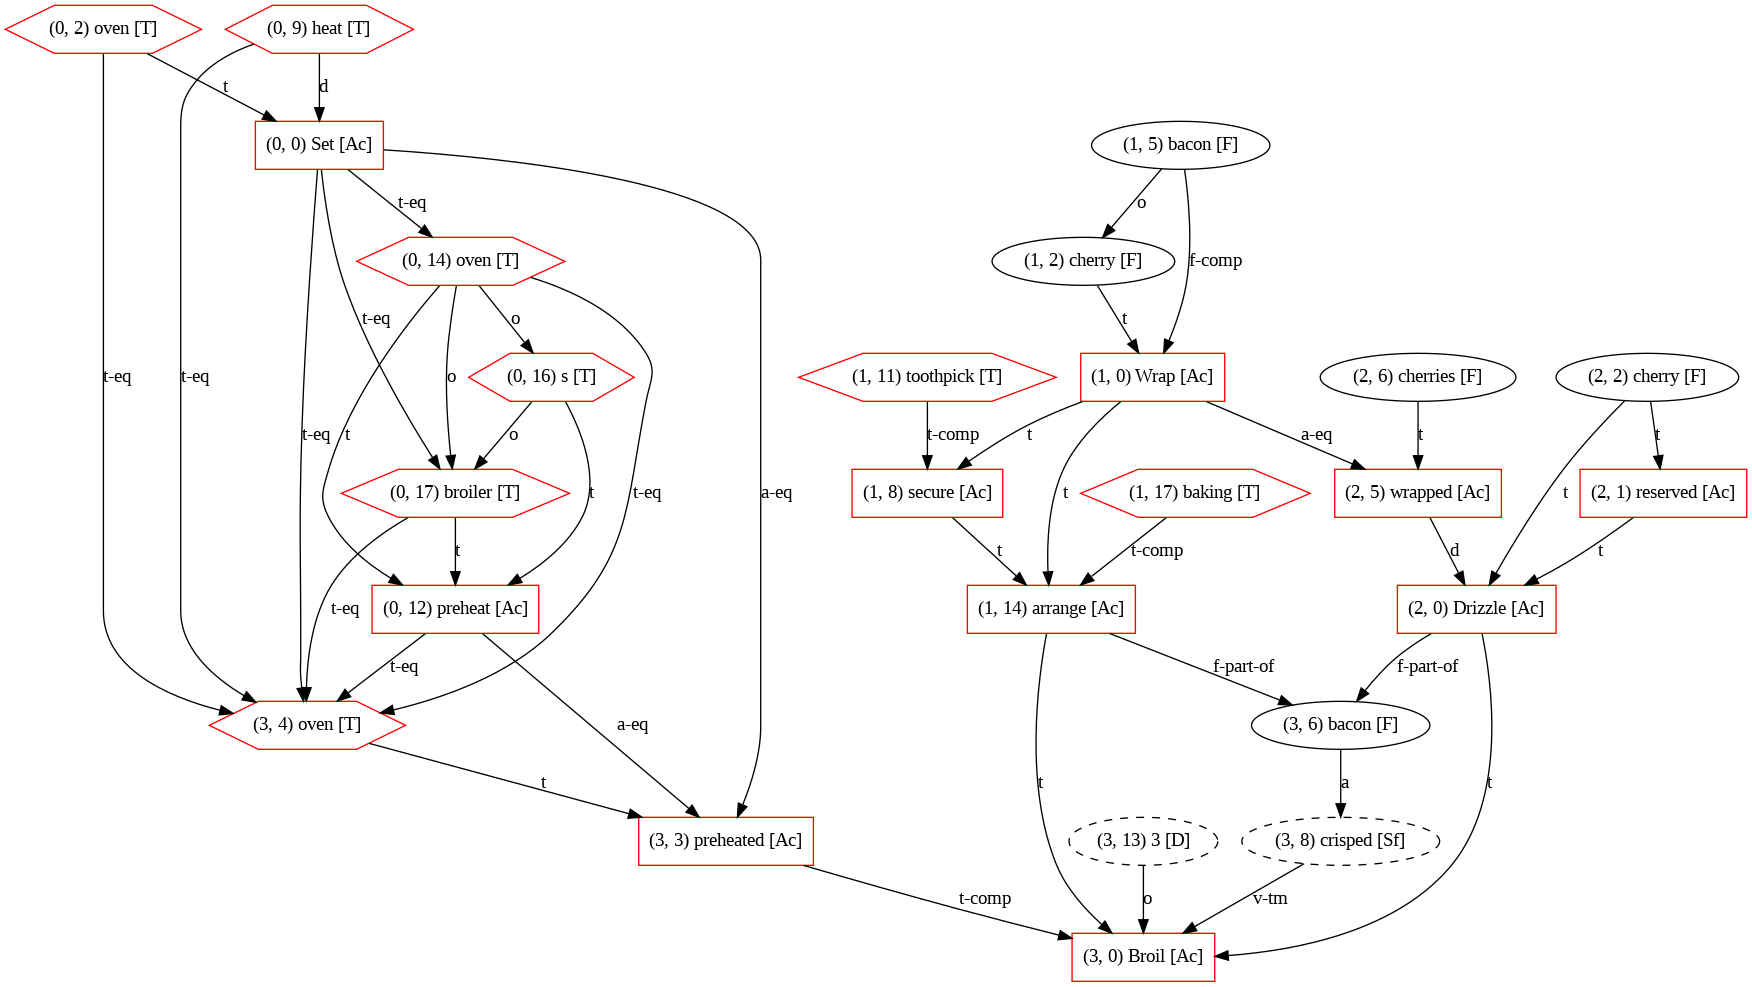

In [209]:
visualize_graph(nodes, edges)
Image(filename='flow_graph.png')